In [1]:
# load all data and graph it
fileToLoad = "./1-100-pololu-motor-120bpm-1kohm-load.csv"
RWind = 60
RSense = (10 / 3)
ISenseGain = 25
VSenseDiv = (220 / (1200 + 220))

import PyQt5
import numpy as np
import matplotlib.pyplot as plt
import pandas
from scipy import signal

d = pandas.read_csv(fileToLoad)
print("CSV file has columns: ")
for (key, value) in d.items():
    print(key)

times = d["Time[s]"][1:].to_numpy().astype(np.float)
IHarvest = (d[" I_harvest"][1:].to_numpy().astype(np.float) / RSense) / ISenseGain
VHarvest = d[" V_harvest"][1:].to_numpy().astype(np.float) / VSenseDiv
Audio = d[" Audio"][1:].to_numpy().astype(np.float)
PHarvest = np.multiply(IHarvest, VHarvest)
VSource = VHarvest + (IHarvest * RWind)

firstdiff = np.zeros(500)
firstdiff[249] = 1
firstdiff[250] = -1
impulse = signal.convolve(signal.hann(500), firstdiff)

VSourceFiltered = signal.convolve(VSource, impulse)[:len(VSource)]

# Just use a simple hystersis based method to find beats
high = np.zeros(len(VSource)).astype(np.int)
hystereticLevels = [3, 2]
hystereticState = 0
beats = []
for i in range(1, len(VSource)):
    high[i] = VSource[i] > hystereticLevels[int(high[i - 1])]
    if ((high[i] == 1) and (high[i-1] == 0)):
        beats.append(i)

print(str(len(beats)) + " beats detected: " + str(beats))

In /home/johnmamish/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/johnmamish/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/johnmamish/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/johnmamish/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/johnmamish/.local/lib/python3.6/site-packages/m

CSV file has columns: 
Time[s]
 I_harvest
 V_harvest
 V_out
 Audio
20 beats detected: [111399, 232196, 356440, 481145, 604259, 725468, 852607, 976736, 1096988, 1222471, 1344207, 1471738, 1598393, 1727671, 1850048, 1974002, 2099462, 2229351, 2347951, 2475991]


<IPython.core.display.Javascript object>


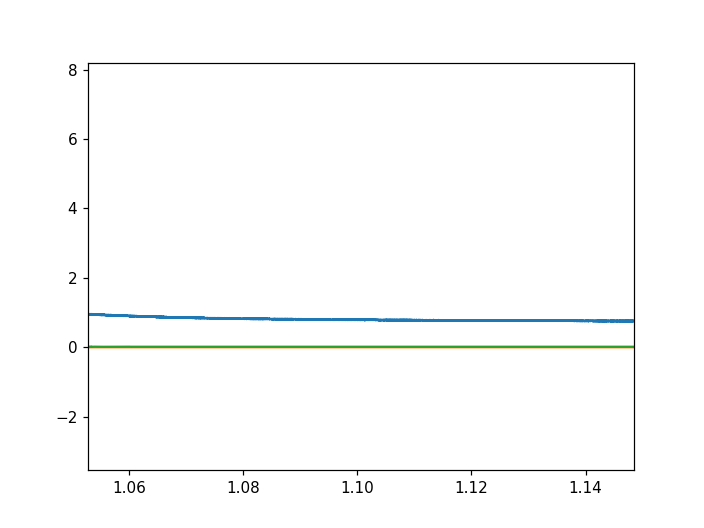

In [2]:
%matplotlib notebook
plt.plot(times, VSource, times, high, times, Audio)

In [35]:
# output VSource to file for ngspice.
# Time scale is 8uS / sample.
samp_interval = 8e-6
tstart = 0.85
tend = 1.1
f = open("motor_voc.m", "w")
for i in np.arange(tstart, tend, samp_interval):
    idx = int(i / samp_interval)
    t = i - tstart
    f.write(str(t) + " " + str(VSource[idx]) + "\n")